In [8]:
import numpy as np
import matplotlib.pyplot as plt
from emcee.autocorr import AutocorrError, integrated_time
from models import *
from samplers import metropolis_sampler
from scipy.stats import loguniform
import random
from icecream import ic
from utils import make_trace_plot
np.random.seed(42)
random.seed(42)

In [9]:

# Load the data.
with open('../lighthouse_flash_data.txt','r') as f:
    data = []
    lines = f.readlines()
    for line in lines:
        fmt_line = line.rstrip().split(' ')
        x = float(fmt_line[0])
        I = float(fmt_line[1])
        data.append([x, I])


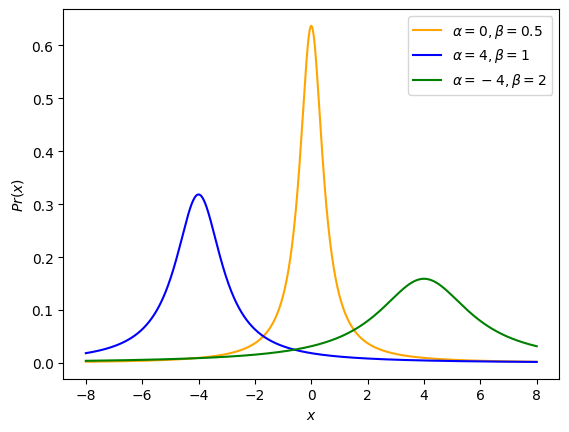

In [10]:
# Plot the cauchy distribution.
def p(x, alpha, beta):
    return beta/(np.pi*(beta**2+(x-alpha)**2))

x = np.linspace(-8, 8, 1000)
plt.plot(x, p(x, 0, 0.5), label=r'$\alpha=0, \beta=0.5$', c='orange')
plt.plot(x, p(x, -4, 1), label=r'$\alpha=4, \beta=1$', c = 'blue')
plt.plot(x, p(x, 4, 2), label=r'$\alpha=-4, \beta=2$', c='green')

# Add vertical lines at the peaks
plt.xlabel('$x$')
plt.ylabel('$Pr(x)$')
plt.legend()
plt.savefig('../report/figs/cauchy_distribution.png')


In [11]:
"""Define the posteriors and prior limits"""
# Prior limits for alpha.
a, b = -100, 100
# Prior limits for beta.
c, d = 0, 50
# Prior limits for I0.
e, f = 1e-4, 1e2

# Define pdf lambda functions.
prior_1 = lambda theta: uniform_2d(theta, a, b, c, d)
prior_2 = lambda theta: log_uniform(theta, e, f)
log_posterior_1 = lambda theta: log_p(theta, data, prior_1)
log_posterior_2 = lambda theta: log_p2(theta, data, prior_1, prior_2)

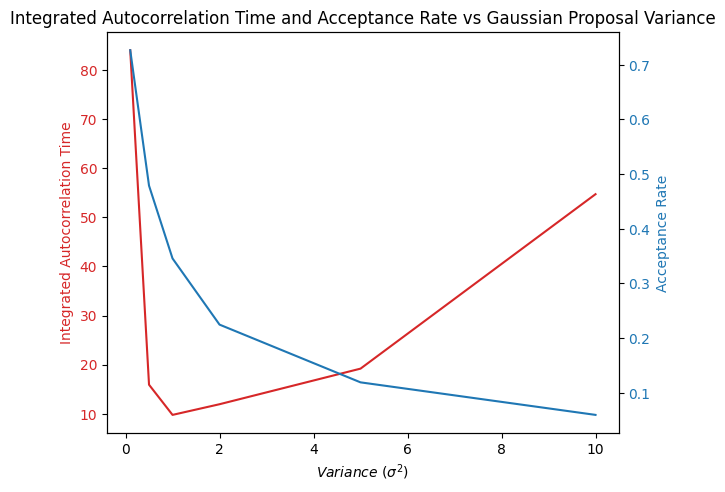

In [57]:
# Tune the proposal covariance matrix for the first sampling.
vars = [0.1, 0.5, 1, 2, 5, 10]
cov_Qs = [np.eye(2) * var for var in vars]
all_acceptances = []
all_max_taus = []
n_chains = range(10)
n_samples = 10000
 
# Initialise lists to store the acceptance rate and max tau.
acceptances = []
max_taus = []

# Start in a good position.
x0 = np.asarray([0, 1])

# Sample using the different proposal covariance matrices.
for cov_Q in cov_Qs:
    samples, acceptance = metropolis_sampler(log_posterior_1, x0, n_samples, cov_Q)
    try:
        # Find the max tau over the the IATs for each variable.
        max_tau = max(integrated_time(samples[:,i]) for i in range(samples.shape[1]))
    except AutocorrError:
        pass
    max_taus.append(max_tau)
    acceptances.append(acceptance)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(r'$Variance \ (\sigma^2)$')
ax1.set_ylabel('Integrated Autocorrelation Time', color=color)
ax1.plot(vars, max_taus, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Acceptance Rate', color=color)
ax2.plot(vars, acceptances, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Integrated Autocorrelation Time and Acceptance Rate vs Gaussian Proposal Variance')
plt.savefig('../report/figs/autocorrelation_time_vs_var.png', dpi=300)
plt.show()


/Users/vishaljain/s2_cw/src/models.py:170: RuntimeWarning: invalid value encountered in log
  log_likelihood_x = sum([np.log(cauchy(x, alpha, beta)) for x, _ in data])
/Users/vishaljain/s2_cw/src/models.py:175: RuntimeWarning: divide by zero encountered in log
  return log_likelihood + np.log(prior_1((alpha, beta))) + np.log(prior_2(I0))
/var/folders/dv/2dpvhcy95qq29g3502cyk9cc0000gn/T/ipykernel_10228/3552915288.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_taus_matrix[i, j] = max_tau
/Users/vishaljain/s2_cw/src/models.py:134: RuntimeWarning: invalid value encountered in log
  mu = np.log(I0 / d**2)


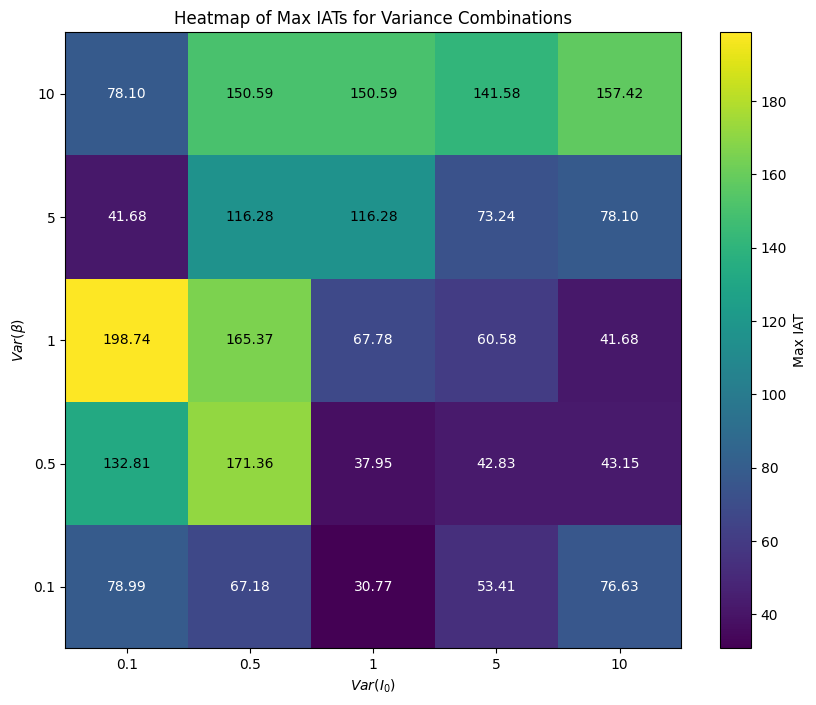

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import random
np.random.seed(42)
random.seed(42)

# Assuming `metropolis_sampler` and `log_posterior_2` are defined elsewhere
# Assuming `integrated_time` correctly calculates the IAT and can raise `AutocorrError`

varBetas = [0.1, 0.5, 1, 5, 10]
varI0s = [0.1, 0.5, 1, 5, 10]
n_samples = 10000

# Initialise a matrix to store the max tau for each combination of varBeta and varI0
max_taus_matrix = np.zeros((len(varBetas), len(varI0s)))

# Initial state
alpha, beta, I0 = 0, 1, 1
x0 = np.asarray([alpha, beta, I0])

# Sample using the different proposal covariance matrices for varBeta and varI0
for i, varBeta in enumerate(varBetas):
    for j, varI0 in enumerate(varI0s):
        # Define the covariance matrix for this combination
        cov_Q = np.eye(3)
        cov_Q[1, 1] = varBeta
        cov_Q[2, 2] = varI0
        
        # Sample
        samples, acceptances = metropolis_sampler(log_posterior_2, x0, n_samples, cov_Q)
        
        try:
            # Calculate the max tau (IAT) for this combination
            max_tau = max(integrated_time(samples[:, k]) for k in range(samples.shape[1]))
        except AutocorrError:
            pass
        
        max_taus_matrix[i, j] = max_tau
# Generate the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(max_taus_matrix, cmap='viridis', origin='lower')
fig.colorbar(cax, label='Max IAT')
ax.set_xticks(np.arange(len(varI0s)))
ax.set_yticks(np.arange(len(varBetas)))
ax.set_xticklabels(varI0s)
ax.set_yticklabels(varBetas)
plt.xlabel(r'$Var(I_0)$')
plt.ylabel(r'$Var(\beta)$')
plt.title('Heatmap of Max IATs for Variance Combinations')

# Define the threshold as the midpoint between the min and max of the matrix values
min_val, max_val = np.nanmin(max_taus_matrix), np.nanmax(max_taus_matrix)
threshold = min_val + (max_val - min_val) * 0.5

# Loop over data dimensions and create text annotations with dynamic color
for i in range(len(varBetas)):
    for j in range(len(varI0s)):
        value = max_taus_matrix[i, j]
        # Choose text color based on the value relative to the threshold
        text_color = "black" if value > threshold else "white"
        ax.text(j, i, f'{value:.2f}', ha="center", va="center", color=text_color)

plt.savefig('../report/figs/IAT_heatmap.png', dpi=300)
plt.show()

In [49]:
from utils import make_trace_plot
import matplotlib.pyplot as plt
import numpy as np

# Load samples
chains_1 = np.load('../chains_1.npy')
chains_2 = np.load('../chains_2.npy')

iid_samples_1 = np.load('../iid_samples_1.npy')
iid_samples_2 = np.load('../iid_samples_2.npy')


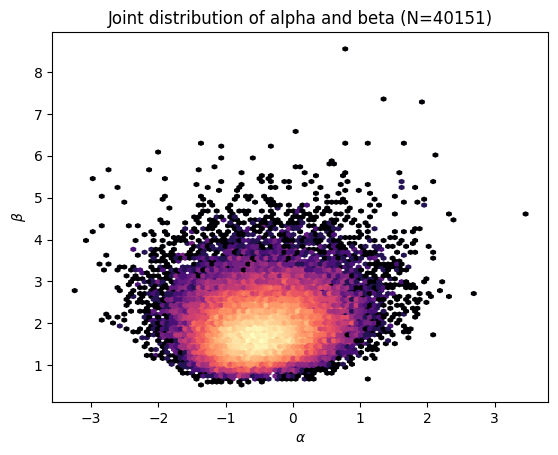

In [50]:
alpha_samples, beta_samples = iid_samples_1[:, 0].flatten(), iid_samples_1[:, 1].flatten()

# First, plot the hexbin heatmap as before
plt.hexbin(alpha_samples, beta_samples, gridsize=100, cmap='magma', bins='log')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.title(f"Joint distribution of alpha and beta (N={len(iid_samples_1)})")
plt.savefig('../report/figs/joint_hist.png', dpi=300)
plt.show()

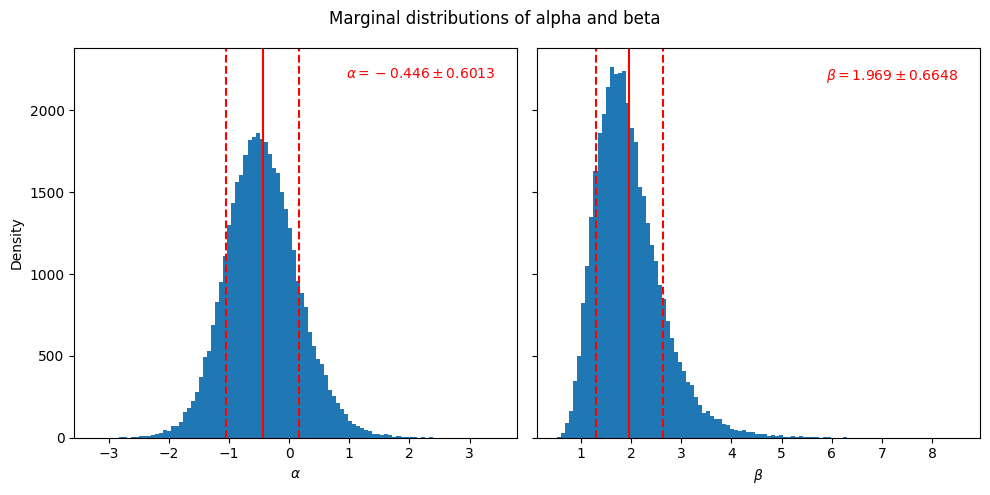

In [51]:
# 1D marginals
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Alpha marginals
ax[0].hist(alpha_samples, bins=100)
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Density')

# Overlay mean and std
mean_alpha = np.mean(alpha_samples)
std_alpha = np.std(alpha_samples)
ax[0].axvline(mean_alpha, color='red', linestyle='-')
ax[0].axvline(mean_alpha + std_alpha, color='red', linestyle='--')
ax[0].axvline(mean_alpha - std_alpha, color='red', linestyle='--')

# Set text for the mean and std
ax[0].text(0.95, 0.95, r"$\alpha = {:.3f} \pm {:.4f}$".format(mean_alpha, std_alpha), 
           verticalalignment='top', horizontalalignment='right', 
           transform=ax[0].transAxes, color='red')

# Beta marginal
ax[1].hist(beta_samples, bins=100)
ax[1].set_xlabel(r'$\beta$')

# Overlay mean and std
mean_beta = np.mean(beta_samples)
std_beta = np.std(beta_samples)
ax[1].axvline(mean_beta, color='red', linestyle='-')
ax[1].axvline(mean_beta + std_beta, color='red', linestyle='--')
ax[1].axvline(mean_beta - std_beta, color='red', linestyle='--')
ax[1].text(0.95, 0.95, r"$\beta = {:.3f} \pm {:.4f}$".format(mean_beta, std_beta), 
           verticalalignment='top', horizontalalignment='right', 
           transform=ax[1].transAxes, color='red')
fig.suptitle('Marginal distributions of alpha and beta')
plt.tight_layout()
plt.savefig('../report/figs/marginals_1.png', dpi=300)
plt.show()


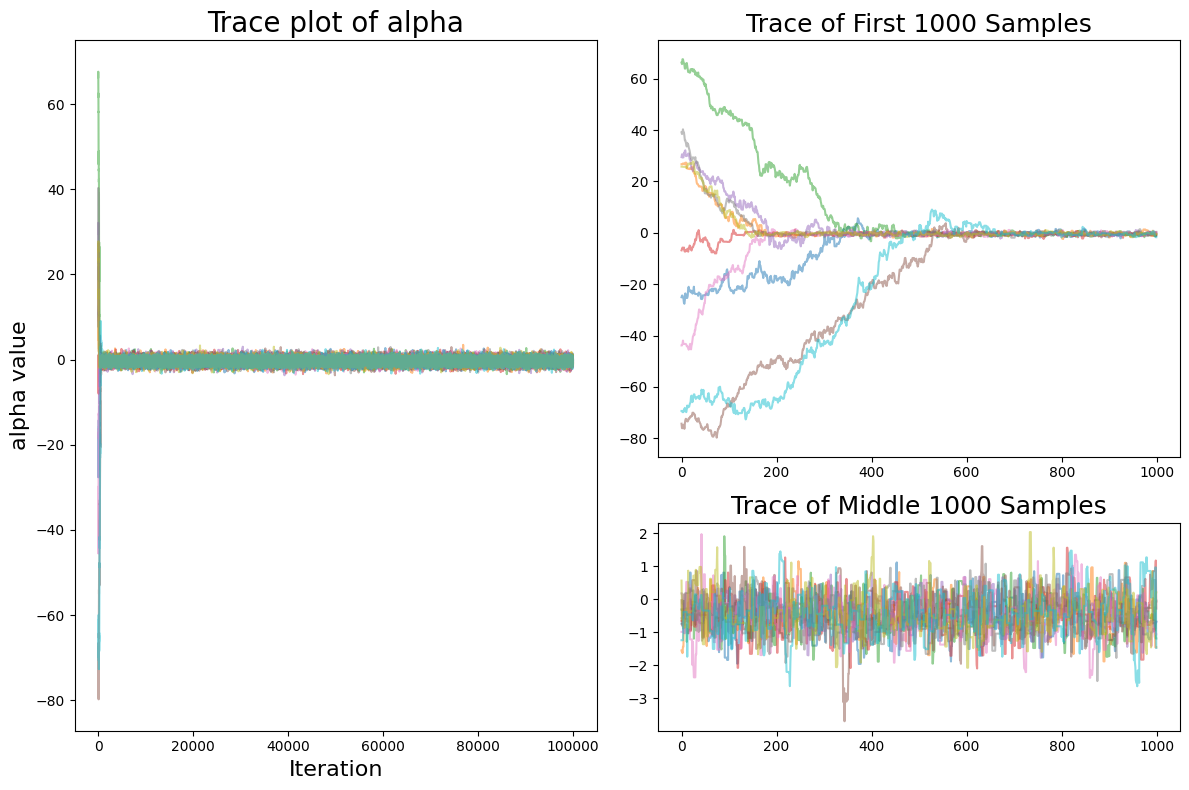

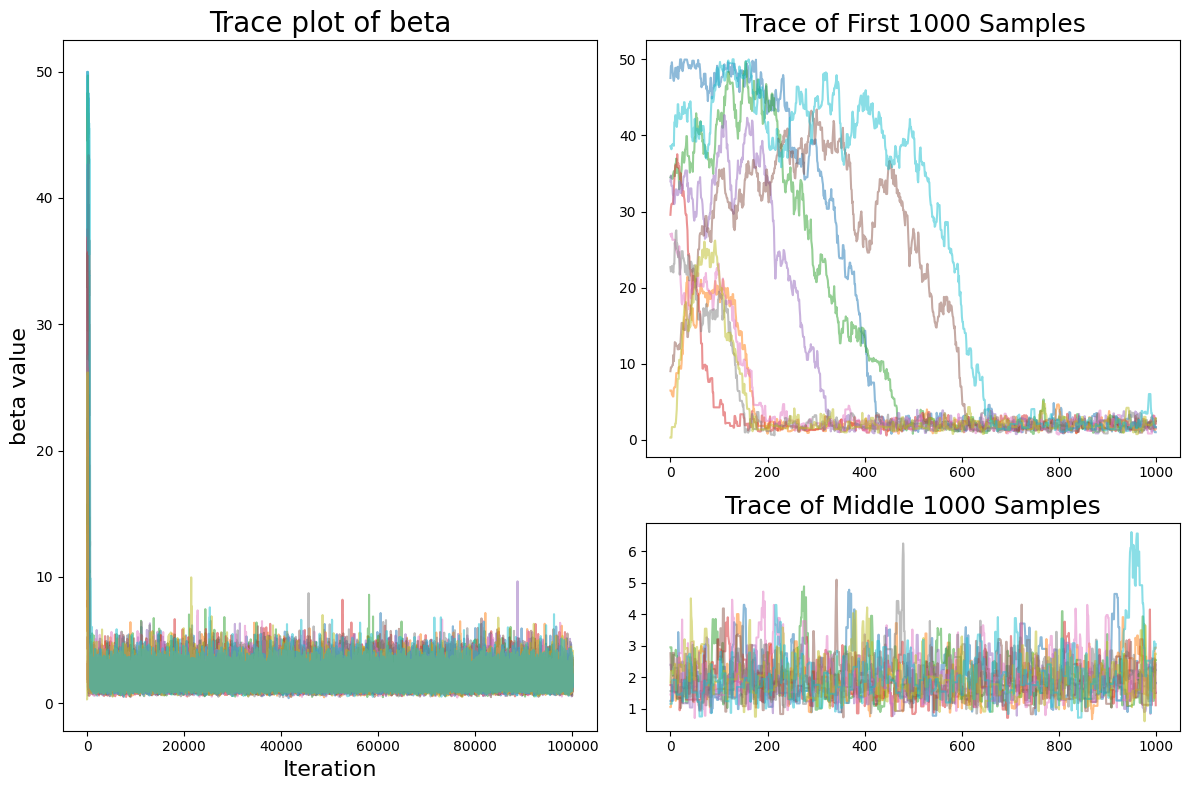

In [52]:
# Trace plot code
plt = make_trace_plot(chains_1, 0, 'alpha')
plt.show()
plt = make_trace_plot(chains_1, 1, 'beta')
plt.show()

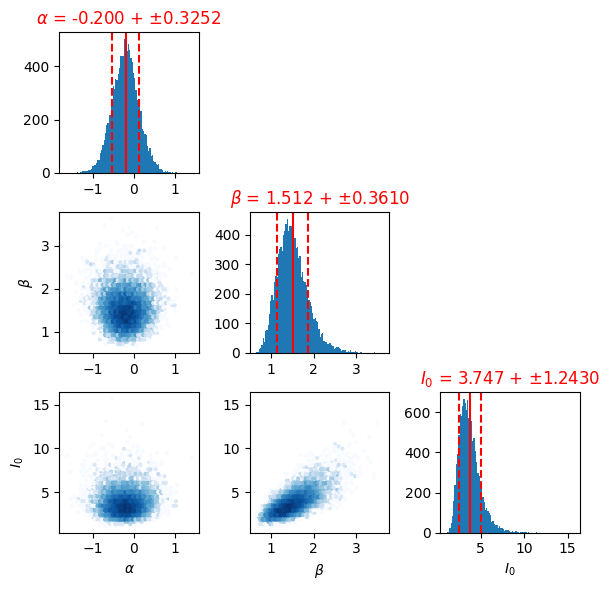

In [54]:

def plot_corner(iid_samples, parameter_names=None):
    """
    Generates a corner plot for the given iid samples.

    Parameters:
    - iid_samples: A 2D numpy array of shape (n_samples, n_parameters).
    - parameter_names: A list of parameter names. Optional.
    """
    n_parameters = iid_samples.shape[1]
    if parameter_names is None:
        parameter_names = [f"Param {i+1}" for i in range(n_parameters)]

    fig, axes = plt.subplots(n_parameters, n_parameters, figsize=(2*n_parameters, 2*n_parameters))

    for i in range(n_parameters):
        for j in range(n_parameters):
            ax = axes[i, j]
            if i == j:  # Plot the marginal distribution
                ax.hist(iid_samples[:, i], bins=100)
                mean = np.mean(iid_samples[:, i])
                std = np.std(iid_samples[:, i])
                ax.axvline(mean, color='red', linestyle='-')
                ax.axvline(mean + std, color='red', linestyle='--')
                ax.axvline(mean - std, color='red', linestyle='--')
                ax.set_title(f"{parameter_names[i]}"+ f" = {mean:.3f} + $\pm {std:.4f}$", color='red')
            elif i > j:  # Plot the hexbin heatmap for joint distributions
                ax.hexbin(iid_samples[:, j], iid_samples[:, i], gridsize=50, cmap='Blues', bins='log')
            else:  # Remove upper triangle
                ax.axis('off')

            # Set labels
            if j == 0 and i > 0:  # Only label the leftmost subplots for clarity
                ax.set_ylabel(parameter_names[i])
            if i == n_parameters-1:  # Only label the bottom subplots for clarity
                ax.set_xlabel(parameter_names[j])

    plt.tight_layout()
    return plt

plt = plot_corner(iid_samples_2, [r'$\alpha$', r'$\beta$', r'$I_0$'])
plt.savefig('../report/figs/corner_plot_2.png', dpi=300, bbox_inches='tight')
plt.show()

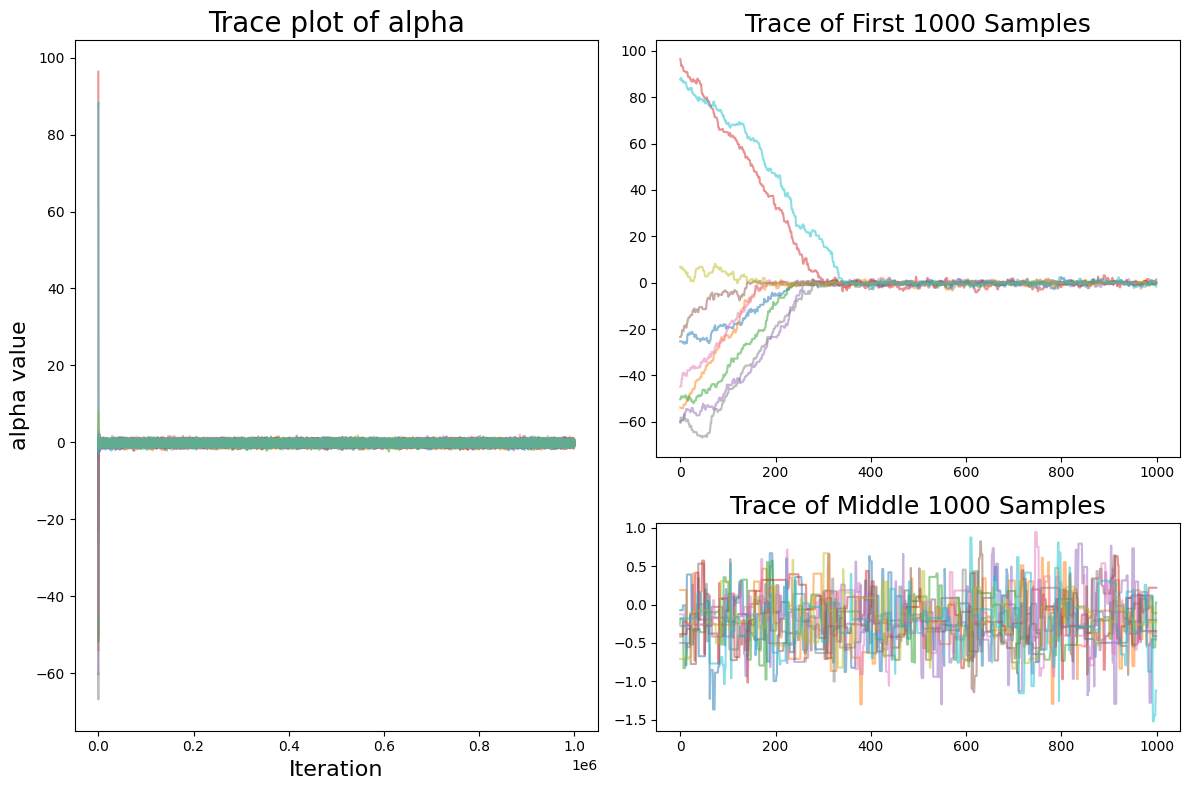

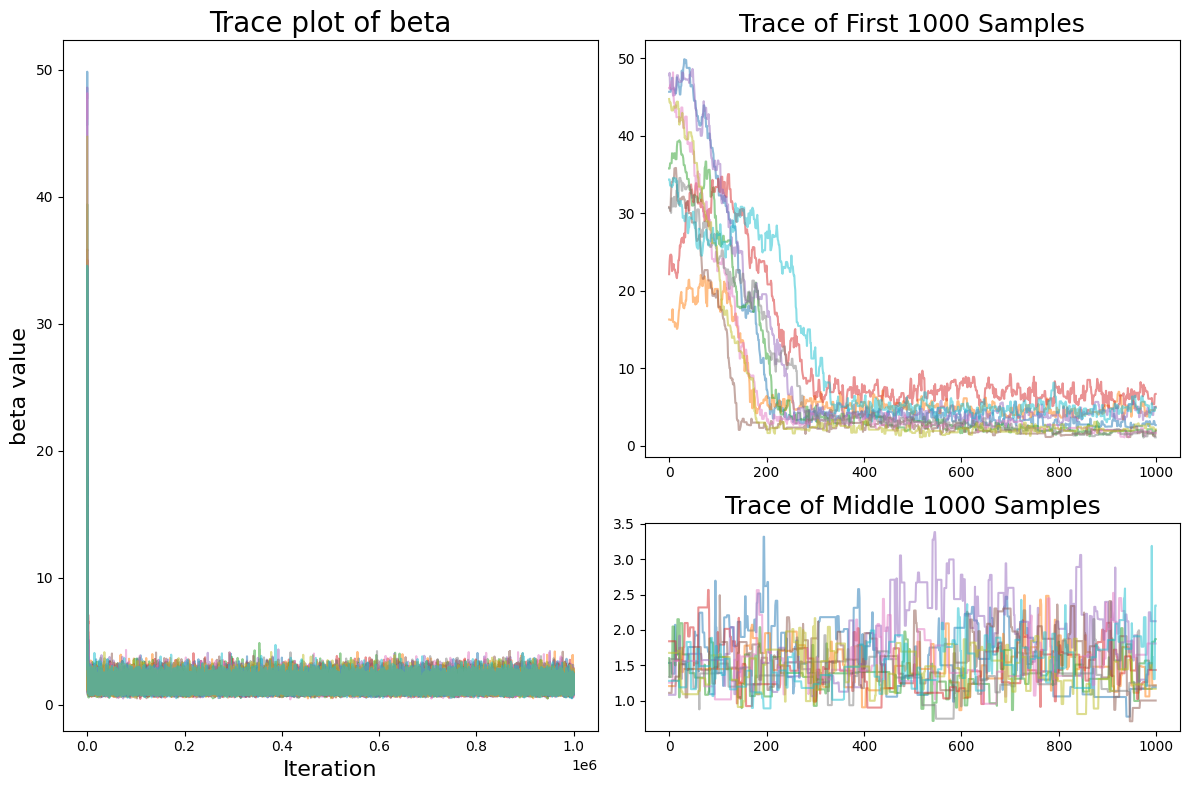

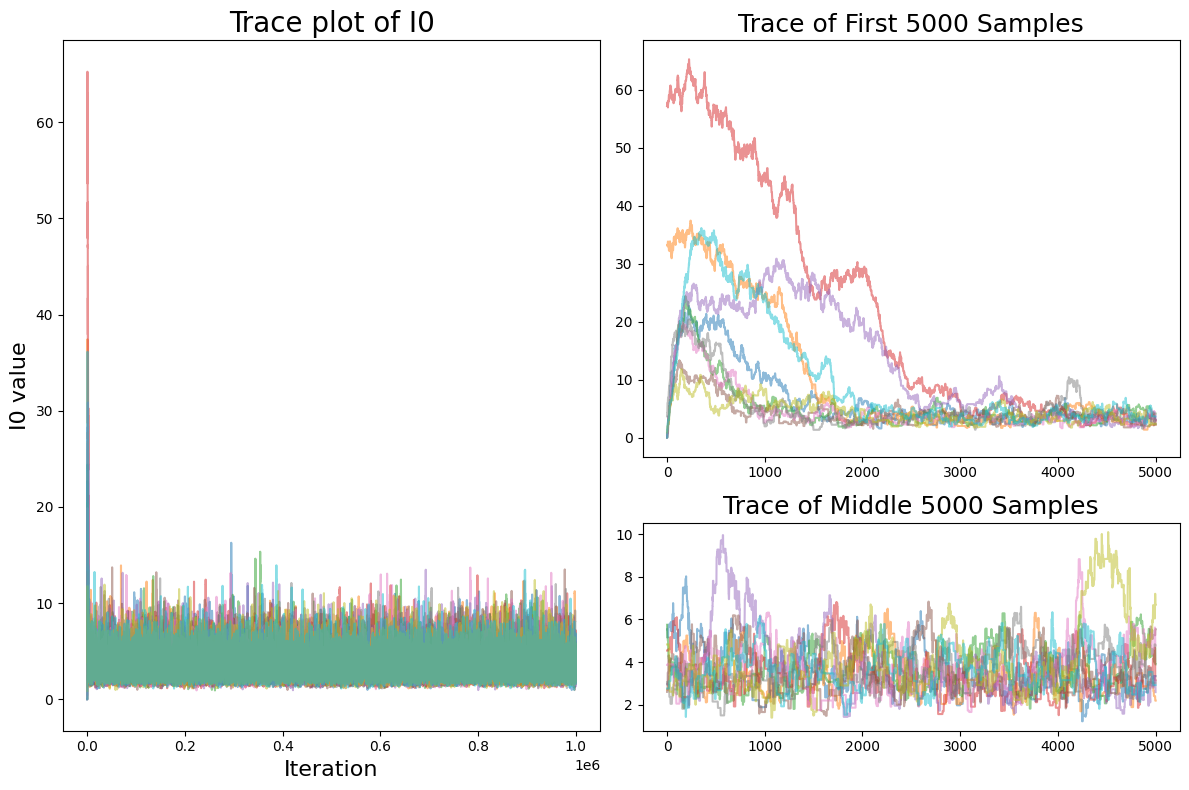

In [6]:
# Trace plots for part 2
plt = make_trace_plot(chains_2, 0, 'alpha', 1000)
plt.show()
plt = make_trace_plot(chains_2, 1, 'beta', 1000)
plt.show()
plt = make_trace_plot(chains_2, 2, 'I0', 5000)
plt.show()